<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/07_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

bme_repo = "https://github.com/jd2504/bme_dsp_2025.git"
repo_name = bme_repo.split('/')[-1].replace('.git', '')
!git clone {bme_repo}
sys.path.append(os.path.join(os.getcwd(), repo_name))
import bmedsp_helpers as bme

Cloning into 'bme_dsp_2025'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 61 (delta 25), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 2.88 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (25/25), done.


1. Simulate a Poisson process and measure count k several times to compute Fano factor F.

2. Test if the counts in the two spike trains in spike.mat could be Poisson? You can use spike
counts or spike intervals to test this.

In [2]:
import numpy as np
from scipy import signal, stats
from matplotlib import pyplot as plt

In [3]:
file_input = bme.grab_mat('spike.mat')

https://parralab.org/teaching/biomed-dsp/spike.mat
dict_keys(['__header__', '__version__', '__globals__', 'x'])
b'MATLAB 5.0 MAT-file, Platform: LNX86, Created on: Sat Sep 28 19:09:03 2002'


In [4]:
x = file_input['x']

In [5]:
np.sum(x, axis=0)

array([ 39, 735], dtype=uint64)

In [6]:
def split_counts(x, split_size=50):
    n_splits = round(len(x)/split_size)
    x = x[:n_splits*split_size]
    # print(f"n splits:{n_splits}")

    splits = np.split(x, n_splits)
    spikes = []
    for i in splits:
        spikes.append(int(np.sum(i)))

    print(f"avg spikes:{np.mean(spikes):0.3f} per window (n={split_size})")

    return spikes


def ff(spike_counts):
    ff = np.var(spike_counts)/np.mean(spike_counts)

    return ff

$ y = -m * \log(1 - u) $

.m: `yrand = -log(1-rand(N,1))*m;`

In [13]:
n = len(x)


# 1st approach: coin flip
px = 0.01

x_r = np.random.choice(
    a=[0, 1], size=n,
    p=[1.0-px, px]
)


# 2nd approach: slide 13 implementation - analytical approach
m = 5
dt = m/100

# y = -m * log(1 - u)
yrand = -np.log(1 - np.random.rand(n, 1)) * m
isi = np.ceil(yrand.flatten() / dt).astype(int)
spike_idx = np.cumsum(np.concatenate(([0], isi)))
spike_idx = spike_idx[spike_idx<n]

yrand_train = np.zeros(n)
yrand_train[spike_idx] = 1

In [14]:
trains = [
    {"name": "spike.mat[0]", "train": x[:,0]},
    {"name": "spike.mat[1]", "train": x[:,1]},
    {"name": "coin flip", "train": x_r},
    {"name": "sample expon", "train": yrand_train}
]

for train in trains:
    print(f"{train["name"]}:")
    train["splits"] = split_counts(train["train"])
    train["ff"] = ff(train["splits"])

spike.mat[0]:
avg spikes:0.049 per window (n=50)
spike.mat[1]:
avg spikes:0.919 per window (n=50)
coin flip:
avg spikes:0.544 per window (n=50)
sample expon:
avg spikes:0.466 per window (n=50)


In [10]:
def plt_spike_train(spike_train, ff, title):
    plt.figure(figsize=(20,1))
    plt.title(f"{title}, F: {ff:0.3f}", loc="left")
    plt.plot(spike_train, lw=0.5)
    plt.axis('off')
    plt.xlim(0,n)
    plt.ylim(0,max(spike_train))
    plt.show()


# sampling from exponential distr... check against theoretical
def plt_isi_pdf(x):
    isis = np.diff(np.where(x)[0])
    m = np.mean(isis)
    x_isi = np.linspace(0, np.max(isis), 500)

    def overlay_expon(m=m):
        from scipy.stats import expon
        return expon.pdf(x_isi, scale=m)
    pdf = overlay_expon()

    plt.figure(figsize=(8, 4))
    plt.hist(isis, bins=100, density=True, alpha=0.7)
    plt.plot(x_isi, pdf)
    plt.axis('off')
    plt.xlim(0,)
    plt.show()

# spike train 1

Only 39 spikes, but Fano-factor very close to 1, indicating Poisson process.

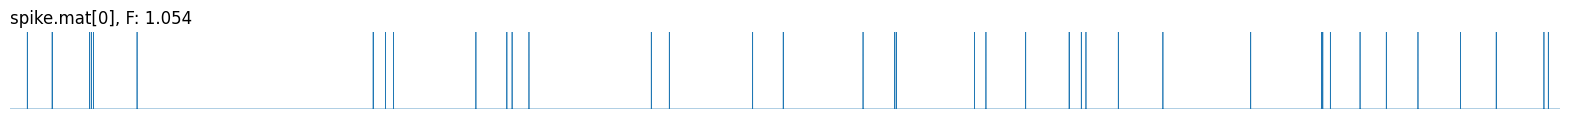

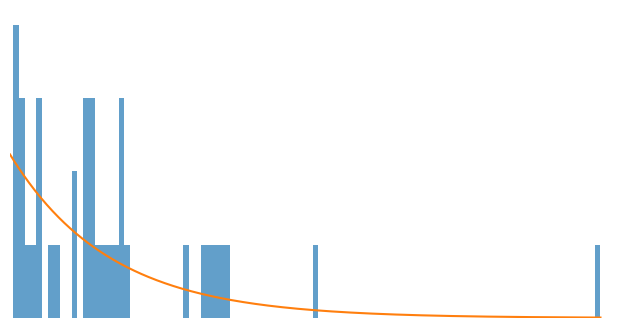

In [11]:
xt = trains[0]

plt_spike_train(xt["train"], xt["ff"], xt["name"])
plt_isi_pdf(xt["train"])

# spike train 2

Fano-factor approx. 0.2, indicating underdispersion. Spike train is not Poisson process.

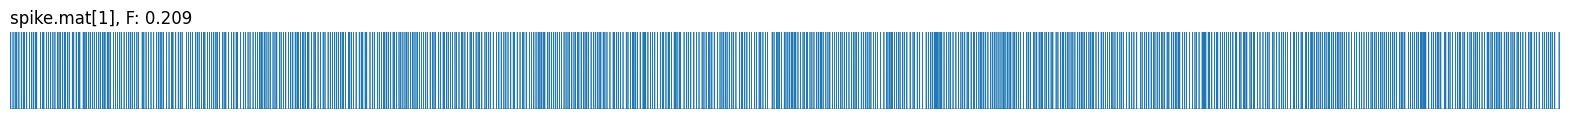

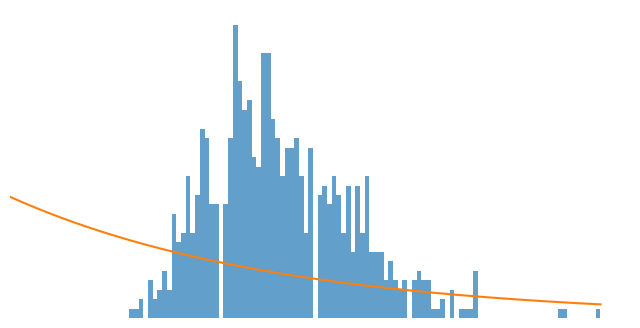

In [31]:
xt = trains[1]

plt_spike_train(xt["train"], xt["ff"], xt["name"])
plt_isi_pdf(xt["train"])

# coin flip

`np.random.choice`

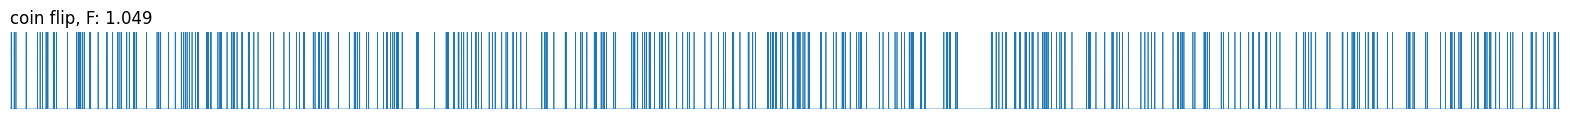

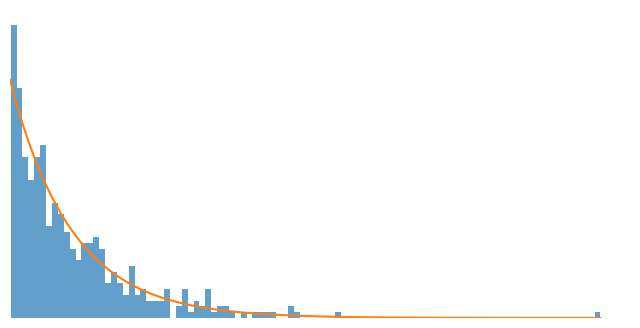

In [15]:
xt = trains[2]

plt_spike_train(xt["train"], xt["ff"], xt["name"])
plt_isi_pdf(xt["train"])

# sample cont. distr., inverse cum. distr.

$ y = -\mu * \log(1 - u) $

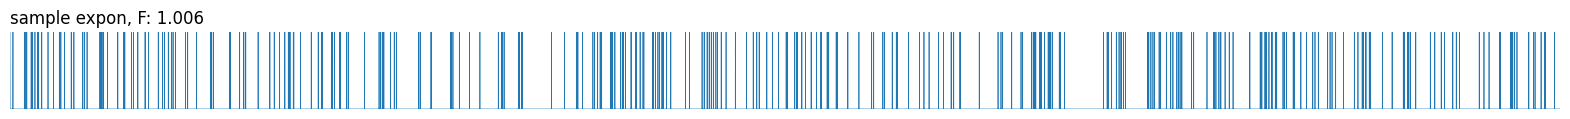

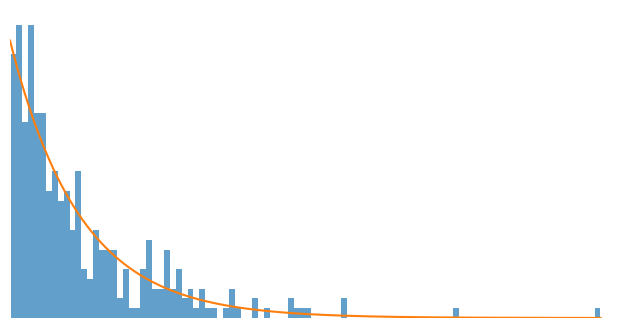

In [22]:
xt = trains[3]

plt_spike_train(xt["train"], xt["ff"], xt["name"])
plt_isi_pdf(xt["train"])